# Homework Assignment 19

We are going to develop a validation (i.e. test) for the multiphase flow simulator we are going to write in the next assignment. We will validate our multiphase flow simulator against the semi-anatlyical Buckley-Leverret solution. Take a look at the class template below, several functions are implemented already, most importantly one called `compute_saturation_profile()`, this function uses the relative permeability properties and Corey-Brooks model to plot the (inadmisable) full saturation profile.  Of course, this profile doesn't take into account the discontinuous shock front of the water displacing the oil in the Buckley-Leverrett problem correctly.  Comparing the mass balance accross the shock-front with the continuum conservation of mass equation leads to an equation

$$
\frac{f(S_{wf})}{S_{wf} - S_{wi}} - \frac{\partial f(S_{wf})}{\partial S} = 0
$$

where $f$ is the fractional flow equation, $S_{wi}$ is the initial water saturation, and $S_{wf}$ is the saturation at the shock front.  This equation can be solved numerically for $S_{wf}$.  Write a function called `compute_saturation_front()` that solves for $S_{wf}$.  My advice is to use the `scipy.optimize.brenth()` function for the nonlinear solve.  Once you know $S_{wf}$, you can truncate the full saturation profile to plot the correct solution.  I've implemented a function `plot_saturation_front(t)`, where $t$ is the time at which you will generate the profile.  A plot for the the non dimensionalized time $t=0.25$ as created with this function is shown.

![img](images/saturation_profile.png)

You can use the plotting functions to help make sense of your solution.  The value of the saturation front at different times will be tested.

In [5]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import yaml

class BuckleyLeverett(object):
    
    def __init__(self, inputs):
        
        if isinstance(inputs, str):
            with open(inputs) as f:
                self.inputs = yaml.load(f, Loader=yaml.FullLoader)
        else:
            self.inputs = inputs
            
        self.Sor = self.inputs['reservoir']['oil']['residual saturation']
        self.Swc = self.inputs['reservoir']['water']['critical saturation']
        self.nw = self.inputs['reservoir']['water']['corey-brooks exponent']
        self.no = self.inputs['reservoir']['oil']['corey-brooks exponent']
        self.krw_max = self.inputs['reservoir']['water']['max relative permeability']
        self.kro_max = self.inputs['reservoir']['oil']['max relative permeability']
        
        self.mu_o = self.inputs['fluid']['oil']['viscosity']
        self.mu_w = self.inputs['fluid']['water']['viscosity']
        
        self.Swi = self.inputs['initial conditions']['water saturation']
        
        self.step = 0.01
    
    def water_rel_perm(self, S):
        return self.krw_max * ((S - self.Swc) / (1 - self.Sor - self.Swc)) ** self.nw
    
    def d_water_rel_perm_dS(self, S):
        return self.nw * self.krw_max * ((- S + self.Swc) / (-1 + self.Sor + self.Swc)) ** self.nw / (S - self.Swc)
    
    def oil_rel_perm(self, S):
        return self.kro_max * (((1 - S) - self.Sor) / (1 - self.Sor - self.Swc)) ** self.no
    
    def d_oil_rel_perm_dS(self, S):
        return self.no * self.kro_max * ((-1 + S + self.Sor) / (-1 + self.Swc + self.Sor)) ** self.no / (-1 + S + self.Sor)
    
    def fractional_flow(self, S):
        krw = self.water_rel_perm(S)
        kro = self.oil_rel_perm(S)
        return (krw / self.mu_w) / (krw / self.mu_w + kro / self.mu_o)
    
    def d_fractional_flow_dkrw(self, S):
        
        kro = self.oil_rel_perm(S)
        krw = self.water_rel_perm(S)
        mu_o = self.mu_o
        mu_w = self.mu_w
        
        return kro * mu_o * mu_w / (krw * mu_o + kro * mu_w) ** 2.0
    
    def d_fractional_flow_dkro(self, S):
        
        kro = self.oil_rel_perm(S)
        krw = self.water_rel_perm(S)
        mu_o = self.mu_o
        mu_w = self.mu_w
        
        return -krw * mu_o * mu_w / (krw * mu_o + kro * mu_w) ** 2.0
    
    def d_fractional_flow_dS(self, S):
        
        df_dkro = self.d_fractional_flow_dkro(S)
        df_dkrw = self.d_fractional_flow_dkrw(S)
        
        dkro_dS = self.d_oil_rel_perm_dS(S)
        dkrw_dS = self.d_water_rel_perm_dS(S)
        
        return df_dkro * dkro_dS + df_dkrw * dkrw_dS
    
    def compute_saturation_front(self):
        
        #Add you implimentation here.
        f = lambda Swf: self.fractional_flow(Swf) / (Swf - self.Swi) - self.d_fractional_flow_dS(Swf)
        
        
        return scipy.optimize.brenth(f, 0.0, 1.0) #return Swf
    
    def compute_saturation_profile(self):
        
        Swi = self.inputs['initial conditions']['water saturation']
        
        S = np.arange(self.Swi + self.step, (1 - self.Swc), self.step)
        
        x = self.d_fractional_flow_dS(S)
        
        return (x, S)
    
    def plot_fractional_flow(self):
        
        S = np.arange(self.Swi + self.step, (1-self.Swc), self.step)
        
        f = self.fractional_flow(S)
        
        plt.plot(S, f)
        plt.xlabel('$S_w$')
        plt.ylabel('$f$')
    
    def plot_full_saturation_profile(self):
        
        x, S = self.compute_saturation_profile()
        
        plt.plot(x, S)
        plt.ylabel('$S_w$')
        plt.xlabel('$x$')
        
    def plot_saturation_profile(self, t):
        
        x, S = self.compute_saturation_profile()
        
        Swf = self.compute_saturation_front()
        
        S1 = S[S > Swf]
        x1 = x[S > Swf] * t
        
        xD = self.d_fractional_flow_dS(Swf) * t
        
        S = np.concatenate((S1[::-1], np.array([Swf, self.Swi]), np.array([self.Swi])))
        x = np.concatenate((x1[::-1], np.array([xD, xD]), np.array([1.0])))
        
        plt.plot(x, S)
        plt.xlabel(r'$x$')
        plt.ylabel(r'$S_w$')

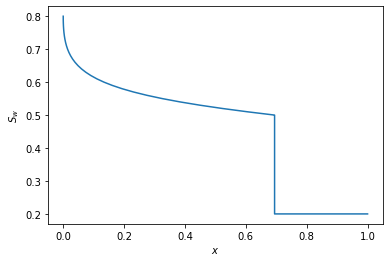

In [6]:
#Uncomment the following lines for viewing the plot
# %matplotlib inline
# pr = BuckleyLeverett('inputs.yml')
# pr.plot_saturation_profile(0.25)

In [7]:
#If you want, uncomment the following lines to produce an interative plot.
# from ipywidgets import interact
# @interact(t=(0,0.44,0.001))
# def iplot(t=0):
#    return pr.plot_saturation_profile(t)

interactive(children=(FloatSlider(value=0.0, description='t', max=0.44, step=0.001), Output()), _dom_classes=(…